In [ ]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import re
import pandas as pd
def build_gate_vocab(bench_dir):
    gate_types = set()
    for filename in os.listdir(bench_dir):
        if filename.endswith(".bench"):
            with open(os.path.join(bench_dir, filename), 'r') as f:
                for line in f:
                    if line.startswith("INPUT"):
                        gate_types.add("INPUT")
                    elif "=" in line:
                        match = re.search(r"=\s*(\w+)\(", line)
                        if match:
                            gate_types.add(match.group(1).upper())
    gate_types = sorted(gate_types)
    return {g: i for i, g in enumerate(gate_types)}

def build_recipe_vocab(*recipe_lists):
    vocab = set()
    for lst in recipe_lists:
        for recipe in lst:
            vocab.update(recipe.strip().split())
    return {step: i for i, step in enumerate(sorted(vocab))}


In [ ]:
import torch
from torch_geometric.data import Data

def parse_bench_file(file_path, gate_to_idx):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    node_names, node_types, edges = [], [], []
    name_to_idx, idx_counter = {}, 0

    for line in lines:
        line = line.strip()
        if line.startswith("INPUT("):
            name = line[6:-1]
            if name not in name_to_idx:
                name_to_idx[name] = idx_counter
                node_names.append(name)
                node_types.append("INPUT")
                idx_counter += 1
        elif "=" in line:
            output, expr = line.split("=")
            output = output.strip()
            gate = expr.strip().split("(")[0]
            inputs = expr.strip().split("(")[1][:-1].split(",")

            if output not in name_to_idx:
                name_to_idx[output] = idx_counter
                node_names.append(output)
                node_types.append(gate.upper())
                idx_counter += 1

            for inp in inputs:
                inp = inp.strip()
                if inp not in name_to_idx:
                    name_to_idx[inp] = idx_counter
                    node_names.append(inp)
                    node_types.append("UNKNOWN")
                    idx_counter += 1
                edges.append((name_to_idx[inp], name_to_idx[output]))

    x = torch.eye(len(gate_to_idx))[torch.tensor([gate_to_idx.get(t, gate_to_idx["INPUT"]) for t in node_types])]
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    return Data(x=x, edge_index=edge_index)


In [ ]:
from torch.utils.data import Dataset

def encode_recipe(recipe, vocab):
    indices = [vocab[step] for step in recipe.strip().split() if step in vocab]
    return torch.tensor(indices, dtype=torch.long)

class QoRDataset(Dataset):
    def __init__(self, df, recipe_vocab, gate_to_idx):
        self.df = df
        self.recipe_vocab = recipe_vocab
        self.gate_to_idx = gate_to_idx

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        graph = parse_bench_file("designs/"+row['Design'], self.gate_to_idx)
        recipe = encode_recipe(row['Recipe'], self.recipe_vocab)
        target = torch.tensor(row['Area'], dtype=torch.float)
        return graph, recipe, target


In [ ]:
import torch.nn as nn
from torch_geometric.nn import GCNConv, global_mean_pool

class GNNLSTMModel(nn.Module):
    def __init__(self, node_feat_dim, recipe_vocab_size, emb_dim=128, lstm_hidden_dim=128):
        super().__init__()
        self.gcn1 = GCNConv(node_feat_dim, 64)
        self.gcn2 = GCNConv(64, 64)

        self.recipe_emb = nn.Embedding(recipe_vocab_size, emb_dim)
        self.lstm = nn.LSTM(emb_dim, lstm_hidden_dim, batch_first=True)

        self.fc = nn.Sequential(
            nn.Linear(64 + lstm_hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, batch):
        graphs, recipes, _ = zip(*batch)

        # Graph part
        x_all, edge_all, batch_indices = [], [], []
        node_count = 0
        for i, g in enumerate(graphs):
            x_all.append(g.x)
            edge_all.append(g.edge_index + node_count)
            batch_indices.append(torch.full((g.num_nodes,), i))
            node_count += g.num_nodes

        x = torch.cat(x_all, dim=0)
        edge_index = torch.cat(edge_all, dim=1)
        batch_tensor = torch.cat(batch_indices)

        x = self.gcn1(x, edge_index).relu()
        x = self.gcn2(x, edge_index).relu()
        graph_emb = global_mean_pool(x, batch_tensor)

        # Recipe part
        padded_recipes = nn.utils.rnn.pad_sequence(recipes, batch_first=True)
        emb = self.recipe_emb(padded_recipes)
        _, (h_n, _) = self.lstm(emb)
        recipe_emb = h_n[-1]

        # Combine
        combined = torch.cat([graph_emb, recipe_emb], dim=1)
        out = self.fc(combined)
        return out.squeeze()


In [ ]:
import math
import matplotlib.pyplot as plt

def train(model, dataloader, optimizer, criterion, epochs=6):
    rmse_per_epoch = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in dataloader:
            pred = model(batch)
            # Fix: Ensure target tensors have at least one dimension
            target = torch.cat([t.unsqueeze(0) if t.dim() == 0 else t for _, _, t in batch])
            loss = criterion(pred, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        rmse = math.sqrt(avg_loss)
        rmse_per_epoch.append(rmse)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, RMSE: {rmse:.4f}")

    # Plot the graph
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), rmse_per_epoch, marker='o', label='RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.title('RMSE vs Epochs')
    plt.legend()
    plt.grid()
    plt.show()



def test(model, dataloader):
    model.eval()
    total_loss = 0
    preds, targets = [], []
    with torch.no_grad():
        for batch in dataloader:
            pred = model(batch)
            # Ensure pred has at least one dimension
            pred = pred.unsqueeze(0) if pred.dim() == 0 else pred
            target = torch.cat([t.unsqueeze(0) if t.dim() == 0 else t for _, _, t in batch])
            preds.append(pred)
            targets.append(target)
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    mse = nn.MSELoss()(preds, targets)
    print(f"Test MSE: {mse.item():.4f}")
    print(f"Test RMSE: {math.sqrt(mse.item()):.4f}")
    return math.sqrt(mse.item())

In [ ]:

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Datasets
df = pd.read_csv("dataset2.csv")
df1 = pd.read_csv("dataset1.csv")
df2 = pd.read_csv("dataset.csv")

#Scaling them into range of big design
df['Area'] = df['Area']*(1000)/(2154)
df1['Area'] = df1['Area']*(1000)/(21615)
df2['Area'] = df2['Area']*(1000)/(64804)

# Build global vocabs
gate_to_idx = build_gate_vocab("designs/")
recipe_vocab = build_recipe_vocab(df['Recipe'], df1['Recipe'],df2['Recipe'])  # Add 3rd df if needed


train_df, test_df = train_test_split(df, test_size=0.15, random_state=42)

train_dataset = QoRDataset(train_df, recipe_vocab, gate_to_idx)
test_dataset = QoRDataset(test_df, recipe_vocab, gate_to_idx)

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True, collate_fn=lambda x: x)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, collate_fn=lambda x: x)


In [ ]:
node_feat_dim = len(gate_to_idx)
recipe_vocab_size = len(recipe_vocab)

model = GNNLSTMModel(node_feat_dim, recipe_vocab_size)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 173299.7348, RMSE: 416.2928
Epoch 2, Loss: 3589.7083, RMSE: 59.9142
Epoch 3, Loss: 3208.9276, RMSE: 56.6474
Epoch 4, Loss: 3511.2522, RMSE: 59.2558
Epoch 5, Loss: 2987.0011, RMSE: 54.6535
Epoch 6, Loss: 3078.8441, RMSE: 55.4873
Epoch 7, Loss: 2947.7915, RMSE: 54.2936
Epoch 8, Loss: 2707.3033, RMSE: 52.0318
Epoch 9, Loss: 2090.4039, RMSE: 45.7209
Epoch 10, Loss: 1241.6707, RMSE: 35.2373
Epoch 11, Loss: 1364.1149, RMSE: 36.9339
Epoch 12, Loss: 1610.4693, RMSE: 40.1307
Epoch 13, Loss: 956.4458, RMSE: 30.9265
Epoch 14, Loss: 526.0911, RMSE: 22.9367
Epoch 15, Loss: 557.6283, RMSE: 23.6142
Epoch 16, Loss: 477.7445, RMSE: 21.8574
Epoch 17, Loss: 364.3308, RMSE: 19.0875
Epoch 18, Loss: 392.6215, RMSE: 19.8147
Epoch 19, Loss: 410.7070, RMSE: 20.2659
Epoch 20, Loss: 416.5289, RMSE: 20.4090


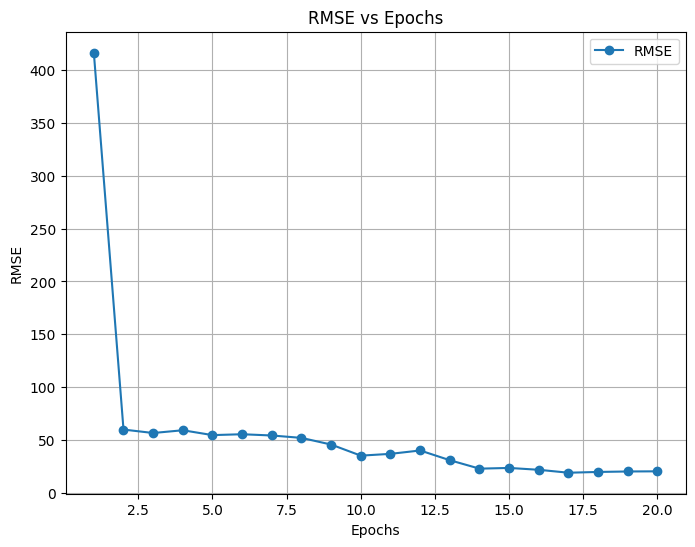

In [ ]:
train(model, train_loader, optimizer, criterion, epochs=20)

In [ ]:
test(model, test_loader)

Test MSE: 676.8384
Test RMSE: 26.0161


26.016118848540923

In [ ]:
import torch

def save_checkpoint(model, optimizer, epoch, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)
    print(f"✅ Saved checkpoint at epoch {epoch} to {path}")

def load_checkpoint(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"🔁 Loaded checkpoint from epoch {start_epoch}")
    return start_epoch


In [ ]:
# 3. Setup checkpoint path (you can change the name or folder)
CHECKPOINT_PATH = "/content/drive/MyDrive/qor_checkpoint4.pth"

In [ ]:
save_checkpoint(model, optimizer, 18, CHECKPOINT_PATH)

✅ Saved checkpoint at epoch 18 to /content/drive/MyDrive/qor_checkpoint4.pth


In [ ]:
load_checkpoint(model, optimizer, CHECKPOINT_PATH)

🔁 Loaded checkpoint from epoch 18


18

# **Test on 2nd design**

In [ ]:
df11 = QoRDataset(df1, recipe_vocab, gate_to_idx)

df1_loader = DataLoader(df11, batch_size=3, shuffle=True, collate_fn=lambda x: x)


In [ ]:
test(model, df1_loader)

Test MSE: 2400.3772
Test RMSE: 48.9936


48.99364445788479

**Now we will train by taking data of both 1st and 2nd deesigns**

In [ ]:
train_df1, test_df1 = train_test_split(df1, test_size=0.15, random_state=42)

train_df11 = pd.concat([train_df, train_df1], ignore_index=True)
train_df11 = train_df11.sample(frac=1).reset_index(drop=True)

test_df11 = pd.concat([test_df, test_df1], ignore_index=True)
test_df11 = test_df11.sample(frac=1).reset_index(drop=True)

train_dataset = QoRDataset(train_df11, recipe_vocab, gate_to_idx)
test_dataset = QoRDataset(test_df11, recipe_vocab, gate_to_idx)

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True, collate_fn=lambda x: x)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, collate_fn=lambda x: x)

Epoch 1, Loss: 766.3039, RMSE: 27.6822
Epoch 2, Loss: 553.9729, RMSE: 23.5366
Epoch 3, Loss: 492.7445, RMSE: 22.1978
Epoch 4, Loss: 539.5141, RMSE: 23.2274
Epoch 5, Loss: 455.4358, RMSE: 21.3409
Epoch 6, Loss: 484.1475, RMSE: 22.0034
Epoch 7, Loss: 421.1906, RMSE: 20.5229
Epoch 8, Loss: 410.0328, RMSE: 20.2493


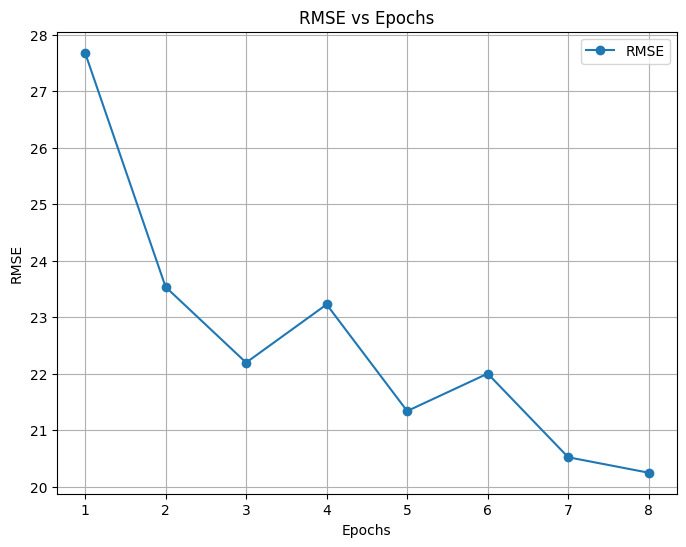

In [ ]:
train(model, train_loader, optimizer, criterion, epochs=8)

In [ ]:
test(model,test_loader)

Test MSE: 566.6769
Test RMSE: 23.8050


23.804975947957026

In [ ]:
CHECKPOINT_PATH2 = "/content/drive/MyDrive/qor_checkpoint5.pth"

In [ ]:
save_checkpoint(model, optimizer, 15, CHECKPOINT_PATH2)

✅ Saved checkpoint at epoch 15 to /content/drive/MyDrive/qor_checkpoint5.pth


In [ ]:
load_checkpoint(model, optimizer, CHECKPOINT_PATH2)

🔁 Loaded checkpoint from epoch 15


15

# **Test on 3rd Design**

In [ ]:
df22 = QoRDataset(df2, recipe_vocab, gate_to_idx)

df2_loader = DataLoader(df22, batch_size=3, shuffle=True, collate_fn=lambda x: x)


In [ ]:
test(model, df2_loader)

Test MSE: 4481.1855
Test RMSE: 66.9417


66.9416577840361

**Train by taking all 3 designs's data**

In [ ]:
train_df2, test_df2 = train_test_split(df2, test_size=0.15, random_state=42)

train_df22 = pd.concat([train_df11, train_df2], ignore_index=True)
train_df22 = train_df22.sample(frac=1).reset_index(drop=True)

test_df22 = pd.concat([test_df11, test_df2], ignore_index=True)
test_df22 = test_df22.sample(frac=1).reset_index(drop=True)

train_dataset = QoRDataset(train_df22, recipe_vocab, gate_to_idx)
test_dataset = QoRDataset(test_df22, recipe_vocab, gate_to_idx)

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True, collate_fn=lambda x: x)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, collate_fn=lambda x: x)

Epoch 1, Loss: 823.5698, RMSE: 28.6979
Epoch 2, Loss: 779.2643, RMSE: 27.9153
Epoch 3, Loss: 773.4586, RMSE: 27.8111
Epoch 4, Loss: 788.4636, RMSE: 28.0796
Epoch 5, Loss: 773.6558, RMSE: 27.8147
Epoch 6, Loss: 736.6615, RMSE: 27.1415
Epoch 7, Loss: 786.4579, RMSE: 28.0439
Epoch 8, Loss: 725.4098, RMSE: 26.9334
Epoch 9, Loss: 759.2115, RMSE: 27.5538
Epoch 10, Loss: 709.1214, RMSE: 26.6293


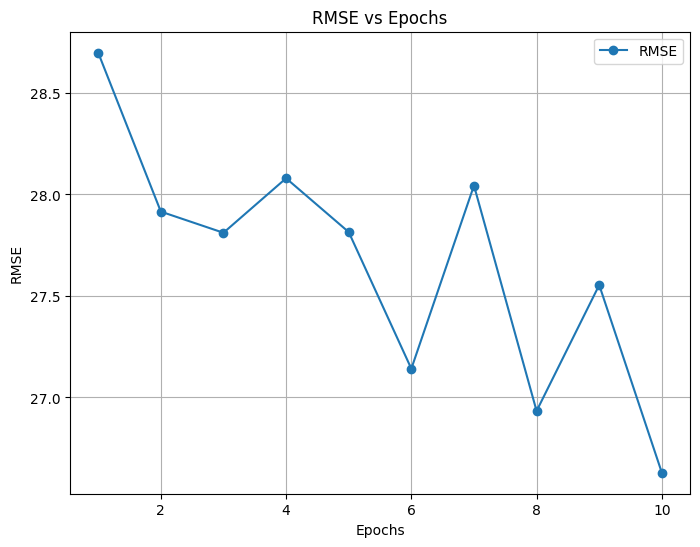

In [ ]:
train(model, train_loader, optimizer, criterion, epochs=10)

In [ ]:
test(model,test_loader)

Test MSE: 733.0599
Test RMSE: 27.0751


27.075078494591317

In [ ]:
CHECKPOINT_PATH3 = "/content/drive/MyDrive/qor_checkpoint8.pth"

In [ ]:
save_checkpoint(model, optimizer, 20, CHECKPOINT_PATH3)

✅ Saved checkpoint at epoch 20 to /content/drive/MyDrive/qor_checkpoint8.pth


In [ ]:
load_checkpoint(model, optimizer, CHECKPOINT_PATH3)

🔁 Loaded checkpoint from epoch 20


20

In [ ]:
def test1(model, dataloader, num_points=10):
    model.eval()
    actuals, predictions = [], []

    with torch.no_grad():
        for batch in dataloader:
            pred = model(batch)
            # Assuming target is in the third position of the batch
            target = torch.cat([t.unsqueeze(0) if t.dim() == 0 else t for _, _, t in batch])
            actuals.extend(target.tolist())
            predictions.extend(pred.tolist())

            # Break early if we've collected enough points
            if len(actuals) >= num_points:
                break

    # Trim to the specified number of points
    return actuals[:num_points], predictions[:num_points]


In [ ]:
test_dataset = QoRDataset(test_df, recipe_vocab, gate_to_idx)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, collate_fn=lambda x: x)
value = test(model,test_loader)
value = value*(2154/1000)
print(f"RMSE after rescaling back:  {value:.4f}")

Test MSE: 394.3627
Test RMSE: 19.8586
RMSE after rescaling back:  42.7754


In [ ]:
from prettytable import PrettyTable
actuals, predictions = test1(model, test_loader)

# Example: Rescale values
rescaled_actuals = [a * (2154/1000) for a in actuals]
rescaled_predictions = [p * (2154/1000) for p in predictions]

table = PrettyTable()
table.field_names = ["Index", "Actual (Rescaled)", "Predicted (Rescaled)"]

for i, (actual, predicted) in enumerate(zip(rescaled_actuals, rescaled_predictions)):
    table.add_row([i + 1, f"{actual:.4f}", f"{predicted:.4f}"])

print(table)

+-------+-------------------+----------------------+
| Index | Actual (Rescaled) | Predicted (Rescaled) |
+-------+-------------------+----------------------+
|   1   |     1842.9999     |      1891.2809       |
|   2   |     1899.0000     |      1890.7190       |
|   3   |     1847.0000     |      1872.8609       |
|   4   |     1802.0001     |      1813.7450       |
|   5   |     1771.0000     |      1817.9632       |
|   6   |     2154.0000     |      2175.0491       |
|   7   |     1819.0000     |      1813.4620       |
|   8   |     1886.0000     |      1856.3894       |
|   9   |     2154.0000     |      2175.0554       |
|   10  |     1708.0000     |      1750.8610       |
+-------+-------------------+----------------------+


In [2]:
test_dataset = QoRDataset(test_df1, recipe_vocab, gate_to_idx)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, collate_fn=lambda x: x)
value = test(model,test_loader)
value = value*(21615/1000)
print(f"RMSE after rescaling back:  {value:.4f}")

Test MSE: 517.2724
Test RMSE: 22.7437
RMSE after rescaling back:  491.6034


In [ ]:
from prettytable import PrettyTable
actuals, predictions = test1(model, test_loader)

# Example: Rescale values
rescaled_actuals = [a * (21615/1000) for a in actuals]
rescaled_predictions = [p * (21615/1000) for p in predictions]

table = PrettyTable()
table.field_names = ["Index", "Actual (Rescaled)", "Predicted (Rescaled)"]

for i, (actual, predicted) in enumerate(zip(rescaled_actuals, rescaled_predictions)):
    table.add_row([i + 1, f"{actual:.4f}", f"{predicted:.4f}"])

print(table)


+-------+-------------------+----------------------+
| Index | Actual (Rescaled) | Predicted (Rescaled) |
+-------+-------------------+----------------------+
|   1   |     18966.0002    |      19279.5457      |
|   2   |     15895.0000    |      16567.6310      |
|   3   |     17561.0002    |      17507.9930      |
|   4   |     17476.0006    |      17338.4279      |
|   5   |     21497.0001    |      20835.4471      |
|   6   |     15970.9995    |      16569.9556      |
|   7   |     18966.0002    |      19402.1261      |
|   8   |     17319.0003    |      17178.4579      |
|   9   |     21615.0000    |      20688.4337      |
|   10  |     19405.9995    |      19150.6341      |
+-------+-------------------+----------------------+


In [1]:
test_dataset = QoRDataset(test_df2, recipe_vocab, gate_to_idx)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, collate_fn=lambda x: x)
value = test(model,test_loader)
value = value*(64804/1000)
print(f"RMSE after rescaling back:  {value:.4f}")

Test MSE: 963.3885
Test RMSE: 31.0385
RMSE after rescaling back:  2011.4190


In [ ]:
from prettytable import PrettyTable
actuals, predictions = test1(model, test_loader)

# Example: Rescale values
rescaled_actuals = [a * (64804/1000) for a in actuals]
rescaled_predictions = [p * (64804/1000) for p in predictions]

table = PrettyTable()
table.field_names = ["Index", "Actual (Rescaled)", "Predicted (Rescaled)"]

for i, (actual, predicted) in enumerate(zip(rescaled_actuals, rescaled_predictions)):
    table.add_row([i + 1, f"{actual:.4f}", f"{predicted:.4f}"])

print(table)


+-------+-------------------+----------------------+
| Index | Actual (Rescaled) | Predicted (Rescaled) |
+-------+-------------------+----------------------+
|   1   |     55357.9982    |      59804.5359      |
|   2   |     57509.9981    |      58779.8385      |
|   3   |     56049.0010    |      55268.0305      |
|   4   |     52011.0006    |      50836.2541      |
|   5   |     61923.9993    |      63444.2947      |
|   6   |     55914.0019    |      56776.9345      |
|   7   |     51155.9984    |      50966.2378      |
|   8   |     61923.9993    |      63444.2947      |
|   9   |     63484.9989    |      58025.3806      |
|   10  |     53044.0002    |      52323.0360      |
+-------+-------------------+----------------------+
